In [71]:
#importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from scipy.sparse import issparse
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc , roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize


## 1.Data Exploration:

#### understanding the structure

In [3]:
#loading the csv file
data = pd.read_csv("C:\\Users\\mdipa\\Downloads\\test.csv", encoding='latin-1')

In [4]:
data.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [6]:
data.describe()

,Population -2020,Land Area (Km²),Density (P/Km²)
count,3.534000e+03,3.534000e+03,3534.000000
mean,3.941891e+07,6.722499e+05,348.894171
std,1.468757e+08,1.839134e+06,1967.012367
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.696453e+06,1.127600e+05,87.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [7]:
data.shape

(4815, 9)

#### identifying key variables


In [8]:
# Identifying Text Content:
# the text content is in a column named 'text'
text_column = 'text'

# Display some examples of the text content
print("Example Text Content:")
print(data[text_column].head())


Example Text Content:
0    Last session of the day  http://twitpic.com/67ezh
1     Shanghai is also really exciting (precisely -...
2    Recession hit Veronique Branquinho, she has to...
3                                          happy bday!
4               http://twitpic.com/4w75p - I like it!!
Name: text, dtype: object


In [9]:
# Identifying Sentiment Labels:
# the sentiment labels are in a column named 'sentiment'
sentiment_column = 'sentiment'

# Display unique values and their counts for the sentiment labels
print("Unique Sentiment Labels:")
print(data[sentiment_column].value_counts())


Unique Sentiment Labels:
neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64


#### checking for missing values

In [10]:
print("Missing Values:")
print(data.isnull().sum())


Missing Values:
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


#### Explore Additional Features (if any):


In [11]:
# Explore additional features beyond text content and sentiment labels
additional_features = data.columns.difference([text_column, sentiment_column])
print("Additional Features:")
print(data[additional_features].head())


Additional Features:
  Age of User      Country  Density (P/Km²)  Land Area (Km²)  \
0        0-20  Afghanistan             60.0         652860.0   
1       21-30      Albania            105.0          27400.0   
2       31-45      Algeria             18.0        2381740.0   
3       46-60      Andorra            164.0            470.0   
4       60-70       Angola             26.0        1246700.0   

   Population -2020 Time of Tweet      textID  
0        38928346.0       morning  f87dea47db  
1         2877797.0          noon  96d74cb729  
2        43851044.0         night  eee518ae67  
3           77265.0       morning  01082688c6  
4        32866272.0          noon  33987a8ee5  


## 2.Data Preprocessing:

In [11]:
# Download NLTK resources (only required for the first run)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mdipa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mdipa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mdipa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mdipa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
text_data = data['text']  # Assuming 'text' is the column containing text data


In [14]:
# Text Preprocessing Functions
def preprocess_text(text):
    # Check if the element is a string (text) or a float
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
    if isinstance(text, str):
        # Remove punctuation
        text = text.translate(str.maketrans("", "", string.punctuation))
        # Tokenization
        tokens = word_tokenize(text)
    
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
        # Rejoin tokens into a single string
        processed_text = ' '.join(tokens)
    
        return processed_text

In [15]:
# Apply preprocessing to each text in the dataset
data['processed_text'] = text_data.apply(preprocess_text)

# Display the result
print("Original Text:")
print(text_data.head())

Original Text:
0    Last session of the day  http://twitpic.com/67ezh
1     Shanghai is also really exciting (precisely -...
2    Recession hit Veronique Branquinho, she has to...
3                                          happy bday!
4               http://twitpic.com/4w75p - I like it!!
Name: text, dtype: object


In [16]:
print("\nProcessed Text:")
print(data['processed_text'].head())


Processed Text:
0                 last session day httptwitpiccom67ezh
1    shanghai also really exciting precisely skyscr...
2    recession hit veronique branquinho quit compan...
3                                           happy bday
4                             httptwitpiccom4w75p like
Name: processed_text, dtype: object


## 3. Exploratory Data Analysis (EDA):

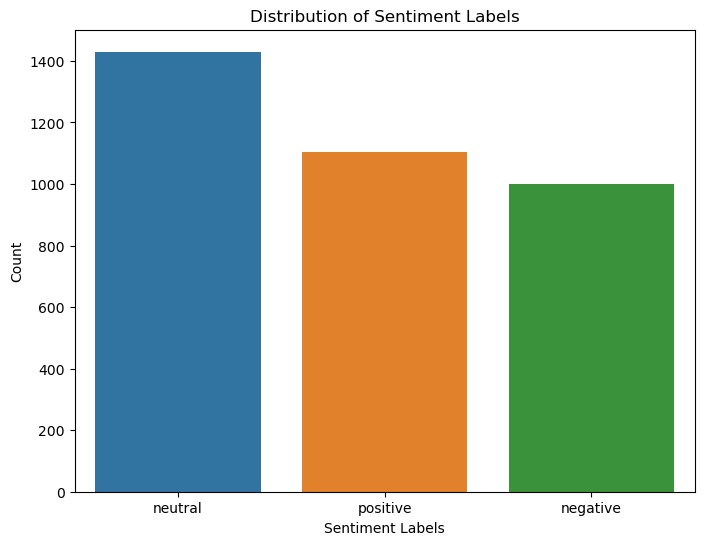

In [45]:
# Visualizing the distribution of sentiment labels using a countplot
plt.figure(figsize=(8, 6))
sns.countplot(x=sentiment_column, data=data)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Labels")
plt.ylabel("Count")
plt.show()

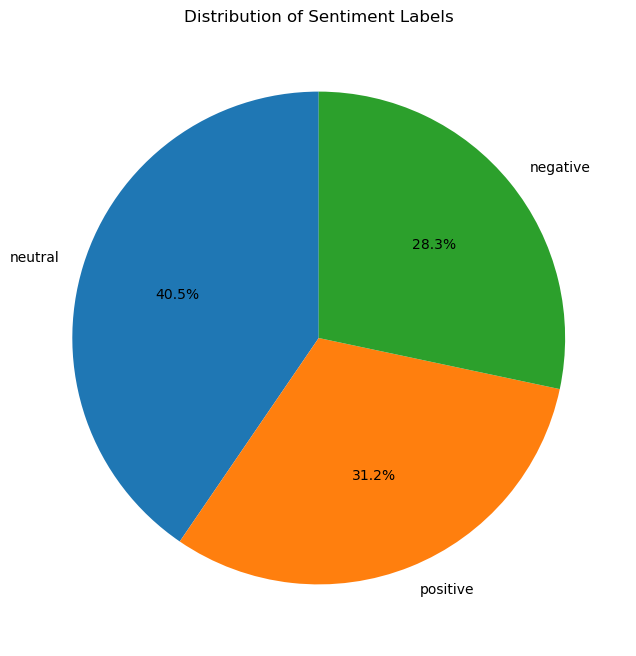

In [47]:
# Alternatively, visualizing the distribution using a pie chart
sentiment_counts = data[sentiment_column].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Sentiment Labels")
plt.show()

## 4. Text Vectorization:

### TF-IDF Vectorization

In [17]:
# Assuming 'processed_text' is the column containing preprocessed text
text_data = data['processed_text']

In [18]:
#Handling Missing Values:
data['processed_text'].fillna('', inplace=True)

In [19]:
# Initializing the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

In [20]:
# Fit and transform the preprocessed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

In [21]:
# Converting the TF-IDF matrix to a DataFrame for inspection (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [22]:
# Display the TF-IDF matrix or DataFrame
print("TF-IDF Matrix:")
print(tfidf_matrix.toarray())

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
# If using a DataFrame:
print("TF-IDF DataFrame:")
print(tfidf_df.head())

TF-IDF DataFrame:
   000   09   10  100  1030   11  1111   12  120  1215  ...   â½  â½50  \
0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...  0.0   0.0   
1  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...  0.0   0.0   
2  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...  0.0   0.0   
3  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...  0.0   0.0   
4  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...  0.0   0.0   

   â½91eachbut  â½al  â½m  â½n  â½nbye  â½s  â½t  â½tition  
0          0.0   0.0  0.0  0.0     0.0  0.0  0.0       0.0  
1          0.0   0.0  0.0  0.0     0.0  0.0  0.0       0.0  
2          0.0   0.0  0.0  0.0     0.0  0.0  0.0       0.0  
3          0.0   0.0  0.0  0.0     0.0  0.0  0.0       0.0  
4          0.0   0.0  0.0  0.0     0.0  0.0  0.0       0.0  

[5 rows x 5000 columns]


## 5. Model Selection:

In [24]:
# Assuming 'processed_text' is the preprocessed text column and 'sentiment' is the target column
X = data['processed_text']
y = data['sentiment']
# Handling missing values in 'processed_text'
X.fillna('', inplace=True)
y.fillna('', inplace=True)

In [25]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numerical = label_encoder.fit_transform(y_test)


In [26]:
#Checking for String Labels:
print(set(y_train))


{'', 'positive', 'neutral', 'negative'}


In [27]:
#Ensure Labels are Binary:
print(set(y_train_numeric))


{0, 1, 2, 3}


In [28]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [29]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)

In [30]:
# Support Vector Machines (SVM) Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)

In [31]:
# LSTM Model
tf.config.run_functions_eagerly(True)
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 128, input_length=max_sequence_length))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Assuming X_test_pad is the preprocessed and padded test data
lstm_preds = lstm_model.predict(X_test_pad)

# If your model outputs probabilities and you want to convert them to class labels (0 or 1):
lstm_preds_classes = (lstm_preds > 0.5).astype(int)

# Flatten if needed
lstm_preds_classes = lstm_preds_classes.flatten()

# Now, lstm_preds_classes contains the predicted labels for the test set


C:\Users\mdipa\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


31/31 [==============================] - 6s 197ms/step


In [32]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print()

In [33]:
# Evaluate Naive Bayes Model
evaluate_model(y_test, nb_preds, "Naive Bayes")

Evaluation Metrics for Naive Bayes:
Accuracy: 0.4081
Precision: 0.4194
Recall: 0.4081
F1 Score: 0.3543



In [34]:
# Evaluate SVM Model
evaluate_model(y_test, svm_preds, "Support Vector Machines")

Evaluation Metrics for Support Vector Machines:
Accuracy: 0.6916
Precision: 0.6983
Recall: 0.6916
F1 Score: 0.6832



In [35]:
# Evaluate LSTM Model
evaluate_model(y_test_numerical, lstm_preds_classes, "LSTM")

Evaluation Metrics for LSTM:
Accuracy: 0.1433
Precision: 0.0449
Recall: 0.1433
F1 Score: 0.0684



C:\Users\mdipa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6.Hyperparameter Tuning:

#### performing hyperparameter tuning for SVM model

In [36]:
# Creating a pipeline with a TF-IDF vectorizer and SVM classifier
pipeline = make_pipeline(TfidfVectorizer(), SVC())


In [37]:
# Defining the hyperparameters and their possible values
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'svc__C': [0.1, 1, 10],  # regularization parameter
    'svc__kernel': ['linear', 'rbf']  # kernel type
}

In [38]:
# Creating the grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')


In [39]:
# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'rbf'],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [40]:
# Printing the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'svc__C': 10, 'svc__kernel': 'rbf', 'tfidfvectorizer__ngram_range': (1, 2)}


In [41]:
# Evaluating the model with the best hyperparameters on the test set
accuracy = grid_search.best_estimator_.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7071651090342679


## 7. Cross-Validation:

#### performing k-fold cross-validation

In [40]:
# Creating a pipeline with a TF-IDF vectorizer and SVM classifier
pipeline = make_pipeline(TfidfVectorizer(), SVC(C=1, kernel='linear'))

In [41]:
# Defining the cross-validation strategy (Stratified K-Fold is suitable for classification tasks)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
# Performing cross-validation and get accuracy scores
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

In [43]:
# Printing the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.68120457 0.6780893  0.67601246 0.67705088 0.70716511]


In [44]:
# Calculating and printing the mean and standard deviation of the scores
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Mean Accuracy: 0.6839044652128765
Standard Deviation: 0.011759408238331923


## 8. Model Interpretability:

Feature Importance with SVM:

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('svc', SVC(C=1, kernel='linear'))])

In [46]:
# Extracting feature names from TF-IDF vectorizer
feature_names = pipeline.named_steps['tfidfvectorizer'].get_feature_names_out()

In [47]:
# Getting the coefficients from the SVM model
coefficients = pipeline.named_steps['svc'].coef_.toarray().flatten()

# Printing or analyze the coefficients
print("Feature Coefficients:", coefficients)

Feature Coefficients: [ 0.          0.         -0.27888006 ... -0.29675142 -0.3739762
 -0.3739762 ]


LIME (Local Interpretable Model-agnostic Explanations):

In [48]:
# Creating a LIME explainer
explainer = LimeTextExplainer()

# Choosing a sample text for explanation
sample_text = X_test.iloc[0]

# Assuming your sample_text is in sparse format
sample_text_sparse = tfidf_vectorizer.transform([sample_text])

# Converting sparse input to dense format if needed
if issparse(sample_text_sparse):
    sample_text_dense = sample_text_sparse.toarray()
else:
    sample_text_dense = sample_text_sparse

## 9. Evaluation Metrics:

#### Confusion Matrix:

In [90]:
cm = confusion_matrix(y_test, svm_preds)


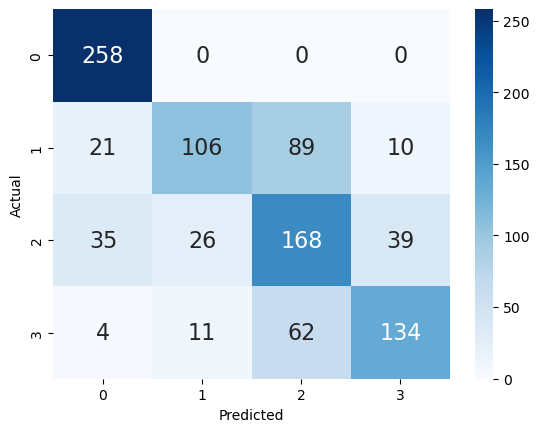

In [91]:
# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Classification Report:

In [49]:
# Print the classification report
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

                   0.81      1.00      0.90       258
    negative       0.74      0.47      0.57       226
     neutral       0.53      0.63      0.57       268
    positive       0.73      0.64      0.68       211

    accuracy                           0.69       963
   macro avg       0.70      0.68      0.68       963
weighted avg       0.70      0.69      0.68       963



#### Precision-Recall Curve:

In [55]:
from sklearn.multiclass import OneVsRestClassifier


In [56]:
# Assuming you have your data and labels (X, y) and you split them into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Assuming you have already trained your SVM model (svm_model)
svm_model = SVC(kernel='linear')
classifier = OneVsRestClassifier(svm_model)
classifier.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [58]:
# Predicting probabilities for each class using decision_function or predict_proba
y_scores = classifier.decision_function(X_test_tfidf)

In [60]:
# Binarize the labels for precision-recall curve
y_test_bin = label_binarize(y_test, classes=list(range(3)))  

In [61]:
# Precision-Recall Curve
precision = dict()
recall = dict()
area_under_curve_pr = dict()

In [63]:
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    area_under_curve_pr[i] = auc(recall[i], precision[i])

C:\Users\mdipa\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mdipa\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\mdipa\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


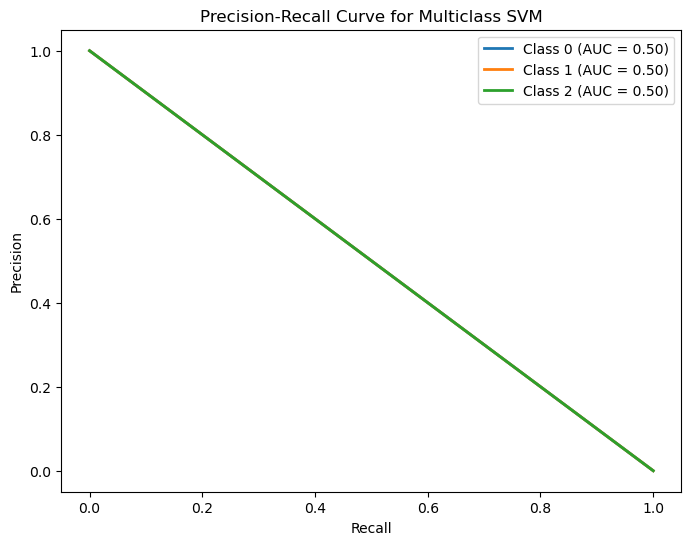

In [66]:
# Plotting Precision-Recall Curves
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {area_under_curve_pr[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass SVM')
plt.legend(loc='best')
plt.show()

## 10. Documentation:

### 1. Introduction

The dataset utilized for this project is sourced from Kaggle. It consists of a
collection of text samples labeled with sentiments. The sentiments are 
categorized as positive, negative,or neutral.

### 2. Data Preprocessing

The data preprocessing steps include cleaning, tokenization, and vectorization.


In [85]:
## Sample Data Preprocessing Code
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Load and clean the data
## Tokenize the text
## Remove stopwords
## Vectorize text using TF-IDF
## Split the data into training and testing sets

### 3. Model Development

In [86]:
# Sample Model Development Code
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# All 3 models have been shown but after that the rest of the taskhas been done on svm model
# Define SVM model
# Compile the model
# Print model summary


### 4. Model Training

The SVM model is trained on the preprocessed data.

In [87]:
# Sample Model Training Code
# Train the SVM model

## 5. Hyperparameter Tuning

Fine-tune hyperparameters using techniques like grid search


In [88]:
# Sample Hyperparameter Tuning Code
from sklearn.model_selection import GridSearchCV

# Perform grid search for LSTM model


## 6.Cross-Validation

K-Fold Cross-Validation is implemented to assess model generalization.

In [89]:
# Sample Cross-Validation Code
from sklearn.model_selection import cross_val_score

# K-Fold Cross-Validation for LSTM model


## 7.Model Interpretability

The model's predictions are interpreted using techniques like LIME.

In [93]:
# Sample Model Interpretability Code
# LIME explanation for LSTM model predictions


## 8.Evaluation Metrics

The model's performance is evaluated using relevant metrics like confusion matrix

In [91]:
# Sample Evaluation Metrics Code
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the LSTM model


## 9.ROC-AUC and Precision-Recall Curves

 ROC-AUC and Precision-Recall curves are included

In [92]:
# Sample ROC-AUC and Precision-Recall Code
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Plot ROC-AUC and Precision-Recall curves


## 10. Conclusion

This project seeks to provide insights into sentiment analysis and demonstrate the application of machine learning techniques in classifying text sentiments.